In [1]:
import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from utils import performance_indicators, calculate_plots, macro_regions

SEED = 42


In [2]:
# read data
df = pd.read_csv("lapse_data.csv")
columns = ['COMP', 'C1', 'PT1', 'SES', 'Age', 'TimeFromStart', 'TimeToExpiry', 'TIPO', 'regione', 'Inflation', 'Eurostoxx', 'DisposableIncome', 'IR', 'Lapsed']
df = df.loc[:, columns]
    

In [3]:
# drop na rows
df = df.dropna()

In [4]:
# categorical features
df["regione"] = df['regione'].map(macro_regions())
df["regione"], _ = pd.factorize(df.regione)
df["TIPO"], _ = pd.factorize(df.TIPO)
df["COMP"], _ = pd.factorize(df.COMP)

In [5]:
# splitting
train_predictors, rest_predictors, train_response, rest_response = train_test_split(
df.drop('Lapsed', axis=1), df['Lapsed'], train_size=0.7, random_state=SEED)
validation_predictors, test_predictors, validation_response, test_response = train_test_split(rest_predictors, rest_response, train_size=0.5, random_state=SEED)
    

In [6]:
parameter_set = [{
        "n_estimators": number_trees,
        "max_depth": 50,
        "min_samples_split": 10,
        "min_samples_leaf": 10,
        "min_impurity_decrease": 0,
        "n_jobs": 4,
        "random_state": SEED
    } for number_trees in [5, 25, 50, 75]]

AUPR:  {'{"n_estimators": 5, "max_depth": 50, "min_samples_split": 10, "min_samples_leaf": 10, "min_impurity_decrease": 0, "n_jobs": 4, "random_state": 42}': 0.5267005550388898, '{"n_estimators": 25, "max_depth": 50, "min_samples_split": 10, "min_samples_leaf": 10, "min_impurity_decrease": 0, "n_jobs": 4, "random_state": 42}': 0.5734210967757493, '{"n_estimators": 50, "max_depth": 50, "min_samples_split": 10, "min_samples_leaf": 10, "min_impurity_decrease": 0, "n_jobs": 4, "random_state": 42}': 0.5628022615839228, '{"n_estimators": 75, "max_depth": 50, "min_samples_split": 10, "min_samples_leaf": 10, "min_impurity_decrease": 0, "n_jobs": 4, "random_state": 42}': 0.5614673111029589}


C:\Users\Daniele\Dropbox\Lavoro\Milano-Politecnico\Didattica\Fintech\Machine Learning\lapse-didattica-master\utils.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()
C:\Users\Daniele\Dropbox\Lavoro\Milano-Politecnico\Didattica\Fintech\Machine Learning\lapse-didattica-master\utils.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


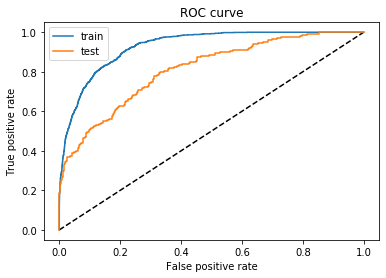

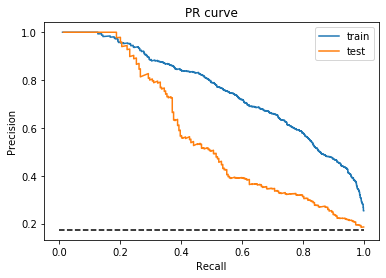

In [7]:
validation_results = {}
for parameters in parameter_set:
        # model definition + training
        classifier = RandomForestClassifier(**parameters)
        classifier.fit(train_predictors, train_response)

        # performance metrics
        performance = performance_indicators(train_predictors,
                                             train_response,
                                             validation_predictors,
                                             validation_response,
                                             classifier)
        validation_results[json.dumps(parameters)] = performance

# choosing best classifier based on validation set
aupr_metrics = {item[0]: item[1].loc['validation', 'aupr'] for item in validation_results.items()}
print("AUPR: ", aupr_metrics)
best_parameters = max(aupr_metrics, key=aupr_metrics.get)
best_classifier = RandomForestClassifier(**json.loads(best_parameters))
best_classifier.fit(train_predictors, train_response)

# plots on test
calculate_plots(train_predictors,
                    train_response,
                    test_predictors,
                    test_response,
                    classifier)

